# <span style="color:red"> Main Modelling - Logistic Regression - Gridsearch </span>

* read in pickle v02
* keep 3 translators
* try different feature sets and save model each time
* compare results at the end
* all features available ie normalised counts and pos counts with some drops plus unique words, adj, adv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load the dataframe containing text chunks and related variables

In [3]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [4]:
df.head(1)

book_chunk_no number                       title  \
0              0      1  Wednesday Afternoon Picnic   

                                                text  \
0  IT WAS A  short one-paragraph item in the morn...   

                                       fstop_indices  \
0  [57, 97, 115, 196, 318, 385, 420, 445, 504, 65...   

                                       split_indices  \
0  [967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...   

                                              chunks       translator  \
0  IT WAS A short one-paragraph item in the morni...  Alfred Birnbaum   

           book_title                                             parsed  \
0  A Wild Sheep Chase  (IT, WAS, A, short, one, -, paragraph, item, i...   

   n_sents  n_words  n_chars  n_syllables  n_unique_words  n_long_words  \
0       15      174      742          240             116            33   

   n_monosyllable_words  n_polysyllable_words  trans_code  chunk_length  \
0                   128                    17           0           944   

   n_sents_norm  n_words_norm  n_chars_norm  n_syllables_norm  \
0     15.889831    184.322034    786.016949        254.237288   

   n_unique_words_norm  n_long_words_norm  n_monosyllable_words_norm  \
0           122.881356          34.957627                  135.59322   

   n_polysyllable_words_norm  vader_compound  vader_neg  vader_neu  vader_pos  \
0                  18.008475         -0.4798      0.075      0.862      0.064   

   pron_count  verb_count  det_count  adj_count  num_count  punct_count  \
0        18.0        20.0       31.0        9.0        2.0         33.0   

   noun_count  adp_count  cconj_count  sconj_count  adv_count  aux_count  \
0        51.0       19.0          6.0          3.0        5.0        5.0   

   part_count  propn_count  space_count  intj_count  sym_count  x_count  ...  \
0         3.0          2.0          0.0         0.0        0.0      0.0  ...   

   then_adv  more_adv  even_adv  why_adv  maybe_adv  again_adv  now_adv  \
0         0         0         1        0          0          0        0   

   just_adv  how_adv  where_adv  very_adv  only_adv  there_adv  still_adv  \
0         0        0          1         0         0          0          0   

   so_adv  too_adv  when_adv  all_adv  here_adv  never_adv  as_adv  new_adj  \
0       0        0         0        0         0          0       0        0   

   other_adj  more_adj  small_adj  deep_adj  whole_adj  first_adj  bad_adj  \
0          0         0          0         0          1          0        0   

   little_adj  next_adj  much_adj  own_adj  hard_adj  last_adj only_adj  \
0           0         0         0        0         0         0        0   

  big_adj right_adj long_adj  old_adj  strange_adj  same_adj  young_adj  \
0       0         0        0        1            0         0          0   

   sure_adj  able_adj  real_adj  different_adj  good_adj  few_adj  \
0         0         0         0              0         0        0   

   vlong_words_count  
0                  0  

[1 rows x 142 columns]

In [5]:
df.shape

(5212, 142)

In [6]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'strange_adj', 'same_adj', 'young_adj', 'sure_adj', 'able_adj',
       'real_adj', 'different_adj', 'good_adj', 'few_adj',
       'vlong_words_count'],
      dtype='object', length=142)

### Check the baseline

In [7]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

## Features = Basic Counts

### Choose features to include in modelling

In [8]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

In [9]:
predictor_cols = feature_select()

### Drop some columns which may be linked to page formatting

In [10]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']

In [11]:
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

### Prepare Target, Predictors
* set X, y based on selected columns
* perform train test split
* normalise predictor variables

In [13]:
def modelling_prep(df, predictor_cols, target_col):
#     set predictor and target variables
    X = df[predictor_cols]
    y = df[target_col]
#     perform train test split, including original indices before shuffling
    indices = list(df.index)
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)
#     normalise the predictor variables 
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test, idx_train, idx_test

In [14]:
X_train, X_test, y_train, y_test, idx_train, idx_test = modelling_prep(df, predictor_cols, 'trans_code')

###  Gridsearch Logistic Regression 

In [15]:
def lr_mc_gridsearch(X_train, y_train):
    # set model
    model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
    # set typical grid search parameters
#     params = {'C': np.logspace(-4, 4, 10),
#           'penalty': ['l1', 'l2'],
#           'fit_intercept': [True, False]}
    params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

    # instantiate model
    model_gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)
    # fit the model
    model_gs.fit(X_train, y_train)
    return model_gs

In [16]:
def lr_gridsearch_score(model, X_train, y_train, X_test, y_test):
    
    # print the grid search results
    results_dict = {}
    print('Best Parameters:')
    print(model.best_params_)
    print('Best estimator mean cross validated training score:')
    print(model.best_score_)
    print('Best estimator score on the full training set:')
    print(model.score(X_train, y_train))
    print('Best estimator score on the test set:')
    print(model.score(X_test, y_test))
    print('ROC-AUC score on the test set:')
    
    # store the grid search results as a dictionary
    y_bin = label_binarize(y_test, model.classes_)
    for i, class_ in enumerate(model.classes_):
        print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],model.predict_proba(X_test)[:,i]),2))
    results_dict['Best_Parameters'] = model.best_params_
    results_dict['Best_CV_Score'] = model.best_score_
    results_dict['Best_Train_Score'] = model.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.score(X_test, y_test)
    results_dict['AUC_Class_0'] = roc_auc_score(y_bin[:,0],model.predict_proba(X_test)[:,0])
    results_dict['AUC_Class_1'] = roc_auc_score(y_bin[:,1],model.predict_proba(X_test)[:,1])
    results_dict['AUC_Class_2'] = roc_auc_score(y_bin[:,2],model.predict_proba(X_test)[:,2])
    predictions = model.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [17]:
lreg_gs_01 = lr_mc_gridsearch(X_train, y_train)

In [18]:
lreg_gs_01_results = lr_gridsearch_score(lreg_gs_01, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 100, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.5236221107147895
Best estimator score on the full training set:
0.5257855600863517
Best estimator score on the test set:
0.5426653883029722
ROC-AUC score on the test set:
Class 0: 0.74
Class 1: 0.77
Class 2: 0.61


In [19]:
lreg_gs_01_results

{'Best_Parameters': {'C': 100, 'penalty': 'l2'},
 'Best_CV_Score': 0.5236221107147895,
 'Best_Train_Score': 0.5257855600863517,
 'Best_Test_Score': 0.5426653883029722,
 'AUC_Class_0': 0.7390432291017816,
 'AUC_Class_1': 0.7679464176174702,
 'AUC_Class_2': 0.6133260640627767,
 'conmat': array([[221, 108,  16],
        [ 86, 322,   8],
        [126, 133,  23]])}

#### There is a very slight improvement over the basic logistic regression - optimizing parameters with gridsearch does not improve accuracy significantly

### Save the model

In [20]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_01'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_01, fp)

## Features = Basic Counts + POS Counts

In [21]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [22]:
X_train, X_test, y_train, y_test, idx_train, idx_test = modelling_prep(df, predictor_cols, 'trans_code')

In [23]:
lreg_gs_02 = lr_mc_gridsearch(X_train, y_train)
lreg_gs_02_results = lr_gridsearch_score(lreg_gs_02, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.5905458586312222
Best estimator score on the full training set:
0.5967857999520269
Best estimator score on the test set:
0.6049856184084372
ROC-AUC score on the test set:
Class 0: 0.79
Class 1: 0.81
Class 2: 0.74


In [25]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_02'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_02, fp)

## Features = Basic Counts + POS Counts + words

In [26]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [29]:
X_train, X_test, y_train, y_test, idx_train, idx_test = modelling_prep(df, predictor_cols, 'trans_code')

In [30]:
lreg_gs_03 = lr_mc_gridsearch(X_train, y_train)
lreg_gs_03_results = lr_gridsearch_score(lreg_gs_03, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.652193539286218
Best estimator score on the full training set:
0.6596306068601583
Best estimator score on the test set:
0.6644295302013423
ROC-AUC score on the test set:
Class 0: 0.82
Class 1: 0.84
Class 2: 0.85


In [31]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_03'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_03, fp)

## Features = Basic Counts + POS Counts + words + adj

In [32]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [33]:
X_train, X_test, y_train, y_test, idx_train, idx_test = modelling_prep(df, predictor_cols, 'trans_code')

In [34]:
lreg_gs_04 = lr_mc_gridsearch(X_train, y_train)
lreg_gs_04_results = lr_gridsearch_score(lreg_gs_04, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6689844283036955
Best estimator score on the full training set:
0.681458383305349
Best estimator score on the test set:
0.6768935762224353
ROC-AUC score on the test set:
Class 0: 0.84
Class 1: 0.84
Class 2: 0.85


In [35]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_04'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_04, fp)

## Features = Basic Counts + POS Counts + words + adj + adv

In [36]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [37]:
X_train, X_test, y_train, y_test, idx_train, idx_test = modelling_prep(df, predictor_cols, 'trans_code')

In [38]:
lreg_gs_05 = lr_mc_gridsearch(X_train, y_train)
lreg_gs_05_results = lr_gridsearch_score(lreg_gs_05, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6764219356807472
Best estimator score on the full training set:
0.7004077716478772
Best estimator score on the test set:
0.6951102588686481
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


In [39]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_05'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_05, fp)

## Features = Basic Counts + POS Counts + words + adj + adv + vader

In [40]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [41]:
X_train, X_test, y_train, y_test, idx_train, idx_test = modelling_prep(df, predictor_cols, 'trans_code')

In [42]:
lreg_gs_06 = lr_mc_gridsearch(X_train, y_train)
lreg_gs_06_results = lr_gridsearch_score(lreg_gs_06, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6828976194794464
Best estimator score on the full training set:
0.708323338930199
Best estimator score on the test set:
0.6883988494726749
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


In [43]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_06'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_06, fp)

## Confusion Matrices

In [44]:
lreg_results = [lreg_gs_01_results,
                lreg_gs_02_results,
                lreg_gs_03_results,
                lreg_gs_04_results,
                lreg_gs_05_results,
                lreg_gs_06_results,]

In [45]:
for i, results in enumerate(lreg_results):
    print(i+1)
    print(pd.DataFrame(results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

1
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 221              108                 16
actual rubin                     86              322                  8
actual gabriel                  126              133                 23
2
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 222               82                 41
actual rubin                     77              310                 29
actual gabriel                   83              100                 99
3
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 229               81                 35
actual rubin                     73              303                 40
actual gabriel                   61               60                161
4
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 233               75    

## Confusion Matrix Comments
* Model 1 - basic counts: does very well for Birnbaum and Rubin but very badly for Gabriel
* Model 2 - basic + POS counts: slight improvement for Birnbaum, a slight drop for Rubin. Gabriel is much improved but still the lowest accuracy
* Model 3 - basic + POS + word counts: Gabriel accuracy imrpoves significantly
* Model 4 - basic + POS + word counts + adj: no significant improvement on the test scores
* Model 5 - basic + POS + word counts + adj + adv: slight improvement across the board
* Model 6 - basic + POS + word counts + adj + adv + vader: no significant improvement on the test scores

## Classification Report
!!! to be set up!!!

In [45]:
# predictions = lreg_gs_01.predict(X_test)
# print(classification_report(y_test, predictions))

In [46]:
model_nums = []
cv_scores = []
train_scores = []
test_scores = []
auc_0 = []
auc_1 = []
auc_2 = []


for i, results in enumerate(lreg_results):
    model_nums.append(i+1)
    cv_scores.append(results['Best_CV_Score'])
    train_scores.append(results['Best_Train_Score'])
    test_scores.append(results['Best_Test_Score'])
    auc_0.append(results['AUC_Class_0'])
    auc_1.append(results['AUC_Class_1'])
    auc_2.append(results['AUC_Class_2'])

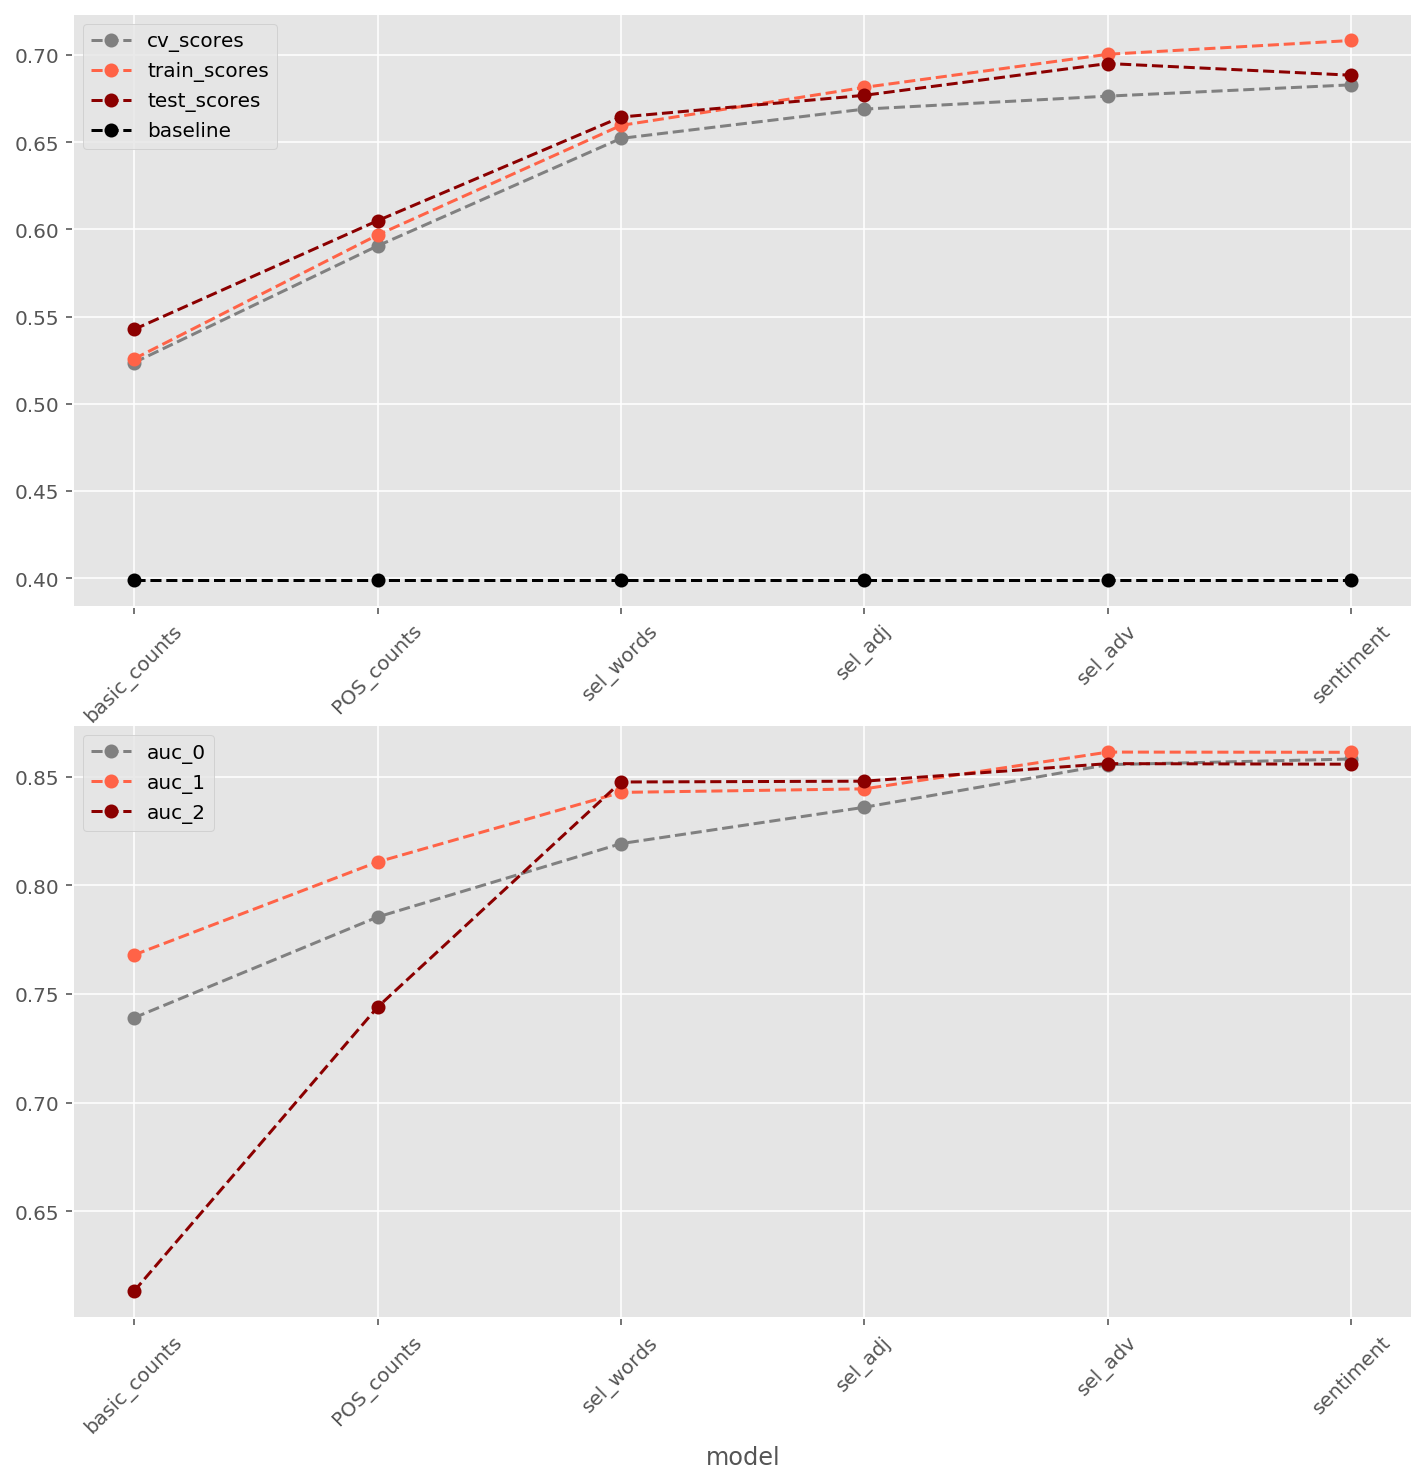

In [47]:
sns.set_palette(['gray', 'tomato', 'darkred', 'black'])
dict_cv_scores = {'model': model_nums, 
                  'cv_scores': cv_scores, 
                  'train_scores': train_scores,
                  'test_scores': test_scores,
                  'auc_0': auc_0,
                  'auc_1': auc_1,
                  'auc_2': auc_2,}
df_cv_scores = pd.DataFrame(dict_cv_scores)
df_cv_scores['baseline'] = baseline_acc

fig, ax = plt.subplots(nrows=2, figsize=(12,12))


df_cv_scores.sort_values(by='model').plot(x='model', y='cv_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='train_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='test_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='baseline', linestyle='--', marker='o', ax=ax[0])

df_cv_scores.sort_values(by='model').plot(x='model', y='auc_0', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_1', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_2', linestyle='--', marker='o', ax=ax[1])

labels = ['', 'basic_counts', 'POS_counts', 'sel_words', 'sel_adj', 'sel_adv', 'sentiment']
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'

ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x', labelrotation=45)




plt.savefig('../../../../Documents/murakami/plots/lreg_sel_feature_scores.png')
plt.show()

## Run a best logistic regression

In [48]:
lreg_gs_06.best_params_

{'C': 1, 'penalty': 'l1'}

In [49]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

indices = list(df.index)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_final = LogisticRegression(C=1, penalty='l1', solver='liblinear', multi_class='ovr', max_iter=1000)

lreg_final.fit(X_train, y_train)
predictions = lreg_final.predict(X_test)
lreg_final.score(X_test, y_test)

0.6951102588686481

In [60]:
# code could be useful for refactoring some of the code above - extracting from tuples/dicts etc to df
# df_pred = pd.DataFrame([(x.r_ui, x.est) for x in predictions_full],
#                        columns=['Rating', 'Predicted'])

In [50]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_final'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_final, fp)

## Precision-Recall Plot

In [51]:
probabilities = lreg_final.predict_proba(X_test)

In [52]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

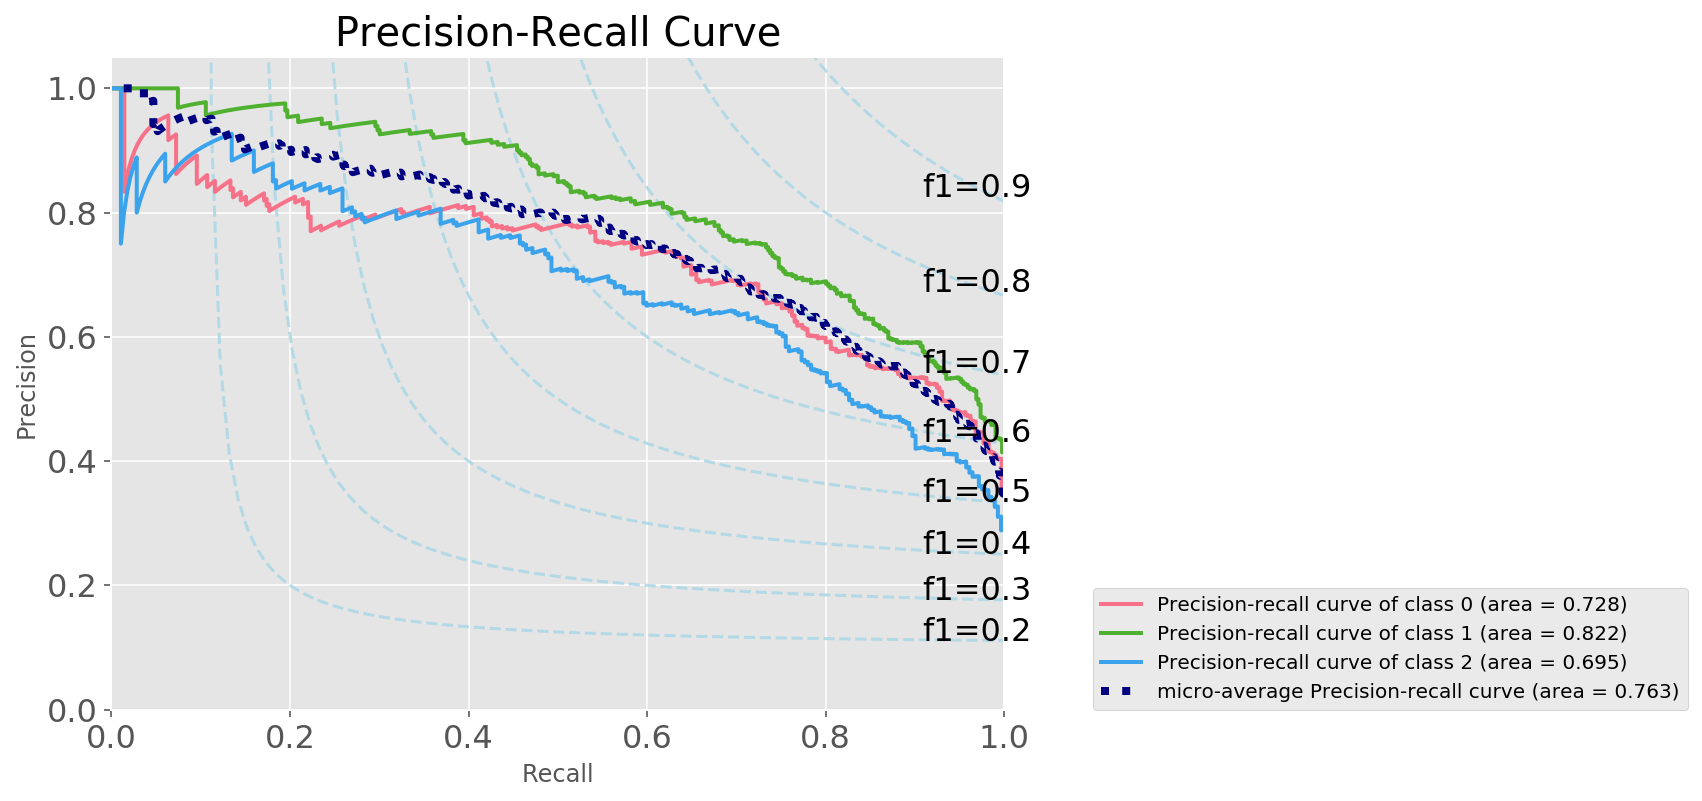

In [53]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [54]:
# label binarizer - not sure if needed?
y_bin = label_binarize(y_test, lreg_final.classes_)

In [55]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(average_precision_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),4))

Area under precision-recall curve:
Class 0: 0.7283
Class 1: 0.8216
Class 2: 0.6949


## ROC Plot

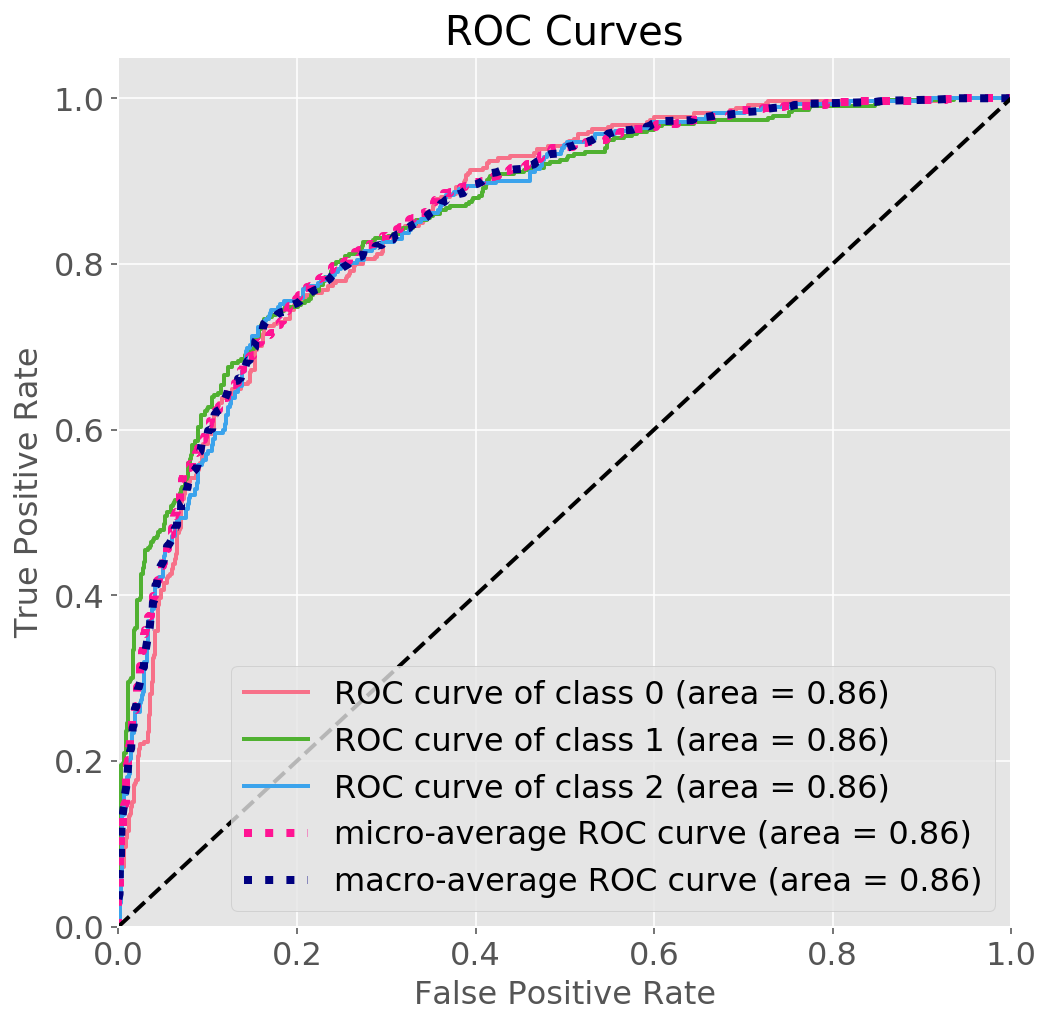

In [56]:
skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,8), cmap=cmap)
plt.show()

In [57]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),2))

Area under ROC curve (ROC-AUC):
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


In [59]:
# skplt.metrics.roc_curve(y_test==0, probabilities[:,0])